# Génération de jeux de données avec TVAE pour voir la variabilité des résultats issus d'un même modèle

Nous générons un certain nombre de jeux de données synthétiques à partir du meilleur modèle obtenu avec la méthode TVAE. Ce modèle a les hyperparamètres suivants:



On fait une boucle pour générer 300 jeux de données et vérifier la variabilité des estimations de certains indicateurs :

- l'effectif de la modalité "RETIRED" pour la variable "socprof"
- le coefficient de corrélation de Pearson entre la variable "height" et "weight"
- l'effectif de la modalité "FEMALE" pour la variable "sex"
- l'effectif de la modalité "YES" pour la variable "alcsol"

On procède par des simulations de Monte-Carlo qui nous permettront d'estimer:

- le biais des estimateurs (écart moyen à la valeur originale);
- la variabilité des estimations (coefficient de variation des estimations).


In [8]:
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sdv.evaluation.single_table import run_diagnostic
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import get_column_pair_plot
from sdv.evaluation.single_table import evaluate_quality
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

os.chdir('/home/onyxia/work/synthetic-data-sdc/')

## Les données SD2011

In [9]:
variables = ['sex','age','agegr','placesize','edu','socprof','marital','ls','depress','trust','trustfam','trustneigh','sport','nofriend','smoke','alcabuse','alcsol','wkabint','englang','height','weight','bmi']

original = pd.read_csv('SDV/df_original.csv', names = variables)

### Les indicateurs à estimer

In [10]:
socprof_count_orig = original['socprof'].value_counts().get('RETIRED', 0)
pearson_corr_orig = original['height'].corr(original['weight'])
female_count_orig = original['sex'].value_counts().get('FEMALE', 0)
alcsol_yes_count_orig = original['alcsol'].value_counts().get('YES', 0)

## A partir d'un modèle TVAE

### Le modèle utilisé

In [11]:
import joblib

model_tvae = joblib.load("SDV/tvae_model_tvae_bs_100_comp_dims_[256, 256]_decomp_dims_[256, 256].pkl")

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be a

### Les hyperparamètres principaux du modèle

In [12]:
model_tvae.batch_size, model_tvae.epochs, model_tvae.compress_dims, model_tvae.decompress_dims, model_tvae.embedding_dim

(100, 300, [256, 256], [256, 256], 128)

### Génération des jeux de données synthétiques

In [13]:
n_sim = 300
results_tvae = np.zeros((n_sim,4))

# np.random.seed(40889) gros problème de sdv => fixer une graine aléatoire ne permet pas d'obtenir un résultat reproductible.

for i in range(n_sim):
    syn = model_tvae.sample(original.shape[0])

    results_tvae[i,0] = syn['socprof'].value_counts().get('RETIRED', 0)
    results_tvae[i,1] = syn['height'].corr(syn['weight'])
    results_tvae[i,2] = syn['sex'].value_counts().get('FEMALE', 0)
    results_tvae[i,3] = syn['alcsol'].value_counts().get('YES', 0)

### Résultats comparatifs

In [43]:
def cummean(np_res):
    np_cs = np.cumsum(np_res, axis=0)
    n, ncol = np_res.shape
    res = np.zeros((n,ncol))
    for j in range(ncol):
        res[0:n,j] = np_cs[0:n,j] / np.arange(1,n+1)
    return res

def cumquant(np_res, prob=0.25):
    n, ncol = np_res.shape
    res = np.zeros((n,ncol))
    for j in range(ncol):
        for i in range(n):
            res[i,j] = np.quantile(np_res[0:i+1,j], prob, axis=0)
    return res
    
valeurs_originales = np.array([ socprof_count_orig, pearson_corr_orig, female_count_orig, alcsol_yes_count_orig])

def biaisrel(np_res):
    moyennes = np.mean(np_res, axis=0)    
    res = (moyennes/valeurs_originales - 1) * 100
    return res

def coeffvar(np_res):
    moyennes = np.mean(np_res, axis=0)    
    stds = np.std(np_res, axis=0)    
    res = (stds/moyennes) * 100
    return res

def all_stats(np_res):
    results = {'cummean': cummean(np_res), 
               'cumq005': cumquant(np_res, 0.05),
               'cumq095': cumquant(np_res, 0.95),
               'biaisrel': biaisrel(np_res),        
               'coeffvar': coeffvar(np_res)
              }
    return results

In [44]:
stats_tvae = all_stats(results_tvae)

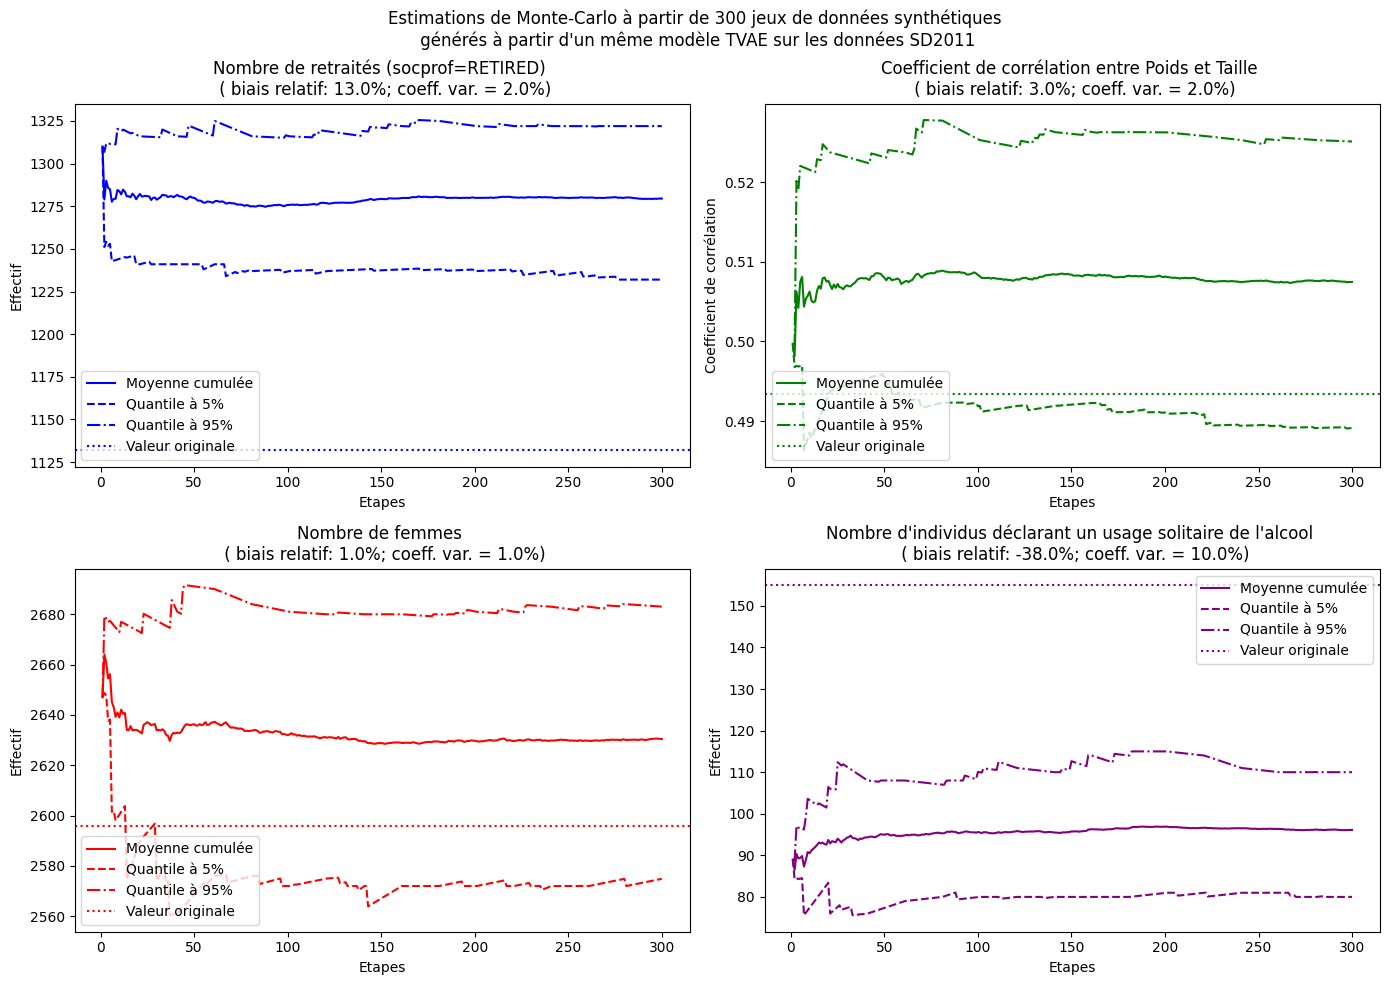

In [64]:
import matplotlib.pyplot as plt

steps = range(1, n_sim+1)

plt.figure(figsize=(14, 10))

plt.suptitle('Estimations de Monte-Carlo à partir de 300 jeux de données synthétiques\n générés à partir d\'un même modèle TVAE sur les données SD2011')

# Graphique 1 : Moyenne cumulée des effectifs de RETIRED
titre = 'Nombre de retraités (socprof=RETIRED) \n ( biais relatif: ' + str(stats_tvae['biaisrel'][0].round()) + '%; coeff. var. = ' + str(stats_tvae['coeffvar'][0].round()) + '%)'
plt.subplot(2, 2, 1)
plt.plot(steps, stats_tvae['cummean'][:,0], color='blue', label = "Moyenne cumulée")
plt.plot(steps, stats_tvae['cumq005'][:,0], color='blue', linestyle='dashed', label = "Quantile à 5%")
plt.plot(steps, stats_tvae['cumq095'][:,0], color='blue', linestyle='dashdot', label = "Quantile à 95%")
plt.axhline(y=socprof_count_orig, color='blue', linestyle='dotted', label = "Valeur originale")
plt.xlabel('Etapes')
plt.ylabel('Effectif')
plt.title(titre)
plt.legend()

# Graphique 2 : Moyenne cumulée des coefficients de Pearson
titre = 'Coefficient de corrélation entre Poids et Taille \n ( biais relatif: ' + str(stats_tvae['biaisrel'][1].round()) + '%; coeff. var. = ' + str(stats_tvae['coeffvar'][1].round()) + '%)'
plt.subplot(2, 2, 2)
plt.plot(steps, stats_tvae['cummean'][:,1], color='green', label = "Moyenne cumulée")
plt.plot(steps, stats_tvae['cumq005'][:,1], color='green', linestyle='dashed', label = "Quantile à 5%")
plt.plot(steps, stats_tvae['cumq095'][:,1], color='green', linestyle='dashdot', label = "Quantile à 95%")
plt.axhline(y=pearson_corr_orig, color='green', linestyle='dotted', label = "Valeur originale")
plt.xlabel('Etapes')
plt.ylabel('Coefficient de corrélation')
plt.title(titre)
plt.legend()

# Graphique 3 : Moyenne cumulée des effectifs de FEMALE
titre = 'Nombre de femmes \n ( biais relatif: ' + str(stats_tvae['biaisrel'][2].round()) + '%; coeff. var. = ' + str(stats_tvae['coeffvar'][2].round()) + '%)'
plt.subplot(2, 2, 3)
plt.plot(steps, stats_tvae['cummean'][:,2], color='red', label = "Moyenne cumulée")
plt.plot(steps, stats_tvae['cumq005'][:,2], color='red', linestyle='dashed', label = "Quantile à 5%")
plt.plot(steps, stats_tvae['cumq095'][:,2], color='red', linestyle='dashdot', label = "Quantile à 95%")
plt.axhline(y=female_count_orig, color='red', linestyle='dotted', label = "Valeur originale")
plt.xlabel('Etapes')
plt.ylabel('Effectif')
plt.title(titre)
plt.legend()

# Graphique 4 : Moyenne cumulée des effectifs de 45-59
titre = 'Nombre d\'individus déclarant un usage solitaire de l\'alcool \n ( biais relatif: ' + str(stats_tvae['biaisrel'][3].round()) + '%; coeff. var. = ' + str(stats_tvae['coeffvar'][3].round()) + '%)'
plt.subplot(2, 2, 4)
plt.plot(steps, stats_tvae['cummean'][:,3], color='purple', label = "Moyenne cumulée")
plt.plot(steps, stats_tvae['cumq005'][:,3], color='purple', linestyle='dashed', label = "Quantile à 5%")
plt.plot(steps, stats_tvae['cumq095'][:,3], color='purple', linestyle='dashdot', label = "Quantile à 95%")
plt.axhline(y=alcsol_yes_count_orig, color='purple', linestyle='dotted', label = "Valeur originale")
plt.xlabel('Etapes')
plt.ylabel('Effectif')
plt.title(titre)
plt.legend()

plt.tight_layout()
plt.show()


## Modèle estimé par un CTGAN

### Le modèle utilisé

In [18]:
model_ctgan = joblib.load("SDV/ctgan_model_epochs_500_bs_100_disc_lr_0.0001_gen_lr_0.0001.pkl")


/opt/conda/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be a

### Les hyperparamètres principaux du modèle

In [19]:
model_ctgan.batch_size, model_ctgan.epochs, model_ctgan.discriminator_lr, model_ctgan.generator_lr, model_ctgan.embedding_dim

(100, 500, 0.0001, 0.0001, 128)

### Génération des jeux de données synthétiques

In [60]:
n_sim = 300
results_ctgan = np.zeros((n_sim,4))

# np.random.seed(40889) gros problème de sdv => fixer une graine aléatoire ne permet pas d'obtenir un résultat reproductible.

for i in range(n_sim):
    syn = model_ctgan.sample(original.shape[0])

    results_ctgan[i,0] = syn['socprof'].value_counts().get('RETIRED', 0)
    results_ctgan[i,1] = syn['height'].corr(syn['weight'])
    results_ctgan[i,2] = syn['sex'].value_counts().get('FEMALE', 0)
    results_ctgan[i,3] = syn['alcsol'].value_counts().get('YES', 0)

### Résultats comparatifs

In [61]:
stats_ctgan = all_stats(results_ctgan)

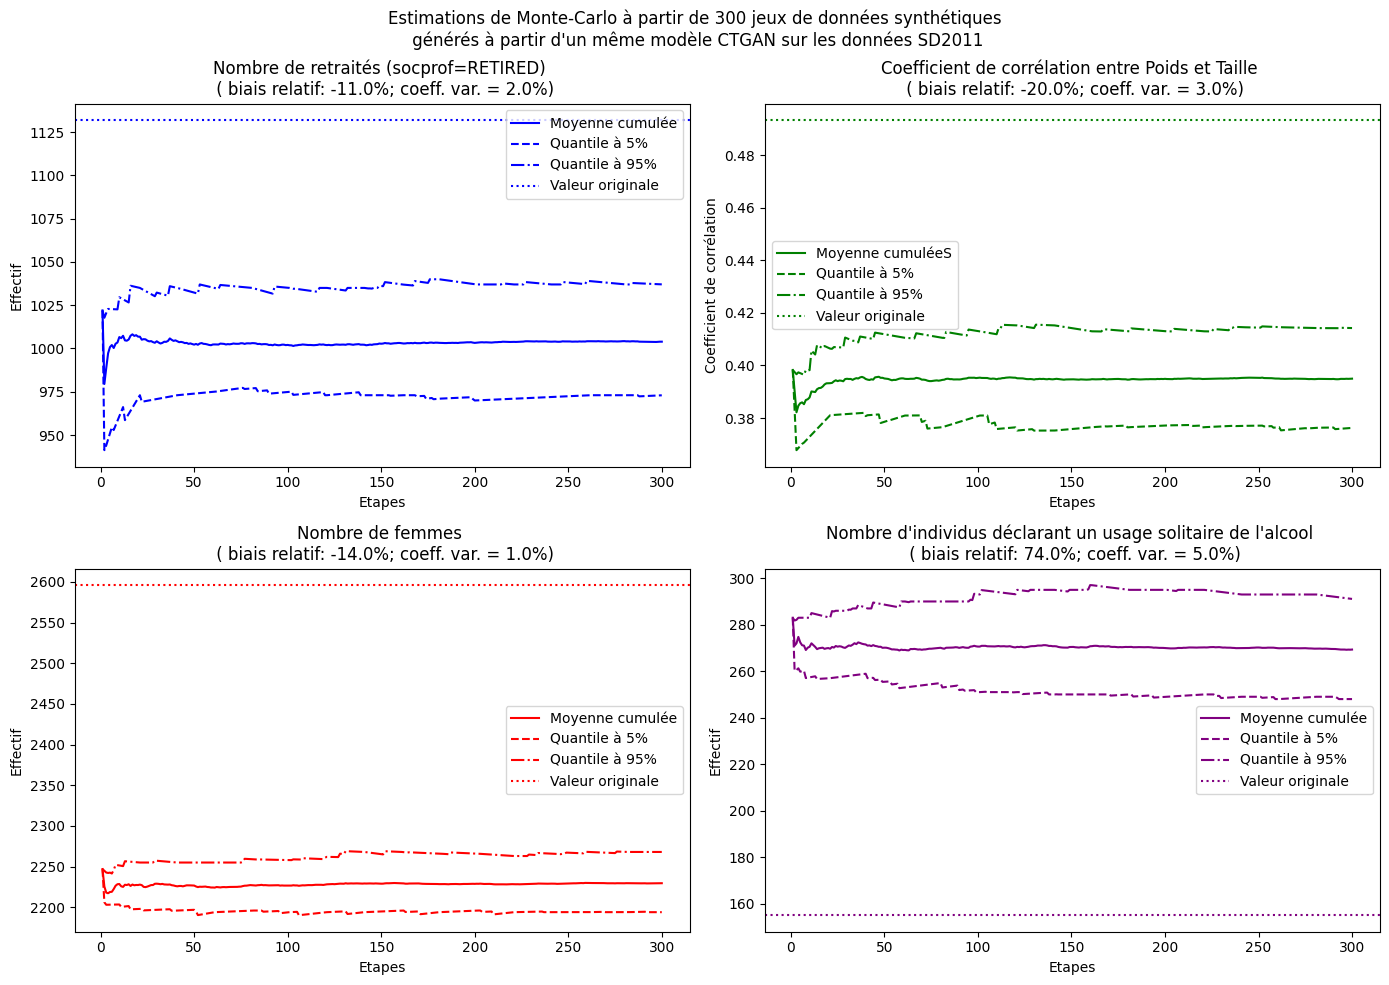

In [65]:
steps = range(1, n_sim+1)

plt.figure(figsize=(14, 10))

plt.suptitle('Estimations de Monte-Carlo à partir de 300 jeux de données synthétiques\n générés à partir d\'un même modèle CTGAN sur les données SD2011')

# Graphique 1 : Moyenne cumulée des effectifs de RETIRED
titre = 'Nombre de retraités (socprof=RETIRED) \n ( biais relatif: ' + str(stats_ctgan['biaisrel'][0].round()) + '%; coeff. var. = ' + str(stats_ctgan['coeffvar'][0].round()) + '%)'
plt.subplot(2, 2, 1)
plt.plot(steps, stats_ctgan['cummean'][:,0], color='blue', label = "Moyenne cumulée")
plt.plot(steps, stats_ctgan['cumq005'][:,0], color='blue', linestyle='dashed', label = "Quantile à 5%")
plt.plot(steps, stats_ctgan['cumq095'][:,0], color='blue', linestyle='dashdot', label = "Quantile à 95%")
plt.axhline(y=socprof_count_orig, color='blue', linestyle='dotted', label = "Valeur originale")
plt.xlabel('Etapes')
plt.ylabel('Effectif')
plt.title(titre)
plt.legend()

# Graphique 2 : Moyenne cumulée des coefficients de Pearson
titre = 'Coefficient de corrélation entre Poids et Taille \n ( biais relatif: ' + str(stats_ctgan['biaisrel'][1].round()) + '%; coeff. var. = ' + str(stats_ctgan['coeffvar'][1].round()) + '%)'
plt.subplot(2, 2, 2)
plt.plot(steps, stats_ctgan['cummean'][:,1], color='green', label = "Moyenne cumuléeS")
plt.plot(steps, stats_ctgan['cumq005'][:,1], color='green', linestyle='dashed', label = "Quantile à 5%")
plt.plot(steps, stats_ctgan['cumq095'][:,1], color='green', linestyle='dashdot', label = "Quantile à 95%")
plt.axhline(y=pearson_corr_orig, color='green', linestyle='dotted', label = "Valeur originale")
plt.xlabel('Etapes')
plt.ylabel('Coefficient de corrélation')
plt.title(titre)
plt.legend()

# Graphique 3 : Moyenne cumulée des effectifs de FEMALE
titre = 'Nombre de femmes \n ( biais relatif: ' + str(stats_ctgan['biaisrel'][2].round()) + '%; coeff. var. = ' + str(stats_ctgan['coeffvar'][2].round()) + '%)'
plt.subplot(2, 2, 3)
plt.plot(steps, stats_ctgan['cummean'][:,2], color='red', label = "Moyenne cumulée")
plt.plot(steps, stats_ctgan['cumq005'][:,2], color='red', linestyle='dashed', label = "Quantile à 5%")
plt.plot(steps, stats_ctgan['cumq095'][:,2], color='red', linestyle='dashdot', label = "Quantile à 95%")
plt.axhline(y=female_count_orig, color='red', linestyle='dotted', label = "Valeur originale")
plt.xlabel('Etapes')
plt.ylabel('Effectif')
plt.title(titre)
plt.legend()

# Graphique 4 : Moyenne cumulée des effectifs de 45-59
titre = 'Nombre d\'individus déclarant un usage solitaire de l\'alcool \n ( biais relatif: ' + str(stats_ctgan['biaisrel'][3].round()) + '%; coeff. var. = ' + str(stats_ctgan['coeffvar'][3].round()) + '%)'
plt.subplot(2, 2, 4)
plt.plot(steps, stats_ctgan['cummean'][:,3], color='purple', label = "Moyenne cumulée")
plt.plot(steps, stats_ctgan['cumq005'][:,3], color='purple', linestyle='dashed', label = "Quantile à 5%")
plt.plot(steps, stats_ctgan['cumq095'][:,3], color='purple', linestyle='dashdot', label = "Quantile à 95%")
plt.axhline(y=alcsol_yes_count_orig, color='purple', linestyle='dotted', label = "Valeur originale")
plt.xlabel('Etapes')
plt.ylabel('Effectif')
plt.title(titre)
plt.legend()

plt.tight_layout()
plt.show()
